<a href="https://colab.research.google.com/github/jaekyoungkim/my_project/blob/main/HAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# https://blog.naver.com/hist0134/221386940063
# http://hist0134.blog.me/221179965199
# https://github.com/hist0613/keras-implementations/blob/main/IMDB-HieAtt.ipynb
# https://github.com/kwonsuhan/Exchange-Rate-Caster/blob/a4dff9961e44572b7a950c347944f3386f9cbe1e/code/han/HAN_model.py
# [Keras] Hierarchical Attention Networks for Document Classification 구현

# 세팅

In [1]:
# IMDB-HieAtt.ipynb
# We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well. 
import keras
from keras import backend as K
import tensorflow as tf

#from keras.engine.topology import Layer 수정해야함
#from tensorflow.python.keras.layers import Layer, InputSpec

from tensorflow.keras.layers import Layer, InputSpec
from keras.layers import Input, Embedding, Dense
from keras.layers import Lambda, Permute, RepeatVector, Multiply
from keras.layers import Bidirectional, TimeDistributed
from keras.layers import CuDNNGRU, GRU
from keras.layers import BatchNormalization, Dropout
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:

!nltk.download('punkt')
import nltk

/bin/bash: -c: line 0: syntax error near unexpected token `'punkt''
/bin/bash: -c: line 0: `nltk.download('punkt')'


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
#4/1AX4XfWgKzT5FnEsEqbHv_MJeAYGD6bx-GaC_4wW5f-wWQPUEX9zI2zEL4ug
# crm = pd.read_csv('gdrive/MyDrive/DW_DATA/CRMDATA_product.csv', encoding = 'c==p949')  # cp949
# CRM품목정리 파일 활용
# utf-8  or cp 949 로 코딩

Mounted at /content/gdrive


In [14]:
# long sentence 할때 이 부분 숫자를 조정해야할듯
# 데이터에서 max(sentence) 값을 적용해야할듯

MAX_SENTENCES = 10
MAX_SENTENCE_LENGTH = 25

# 데이터불러오기 

In [4]:
# refer: http://ai.stanford.edu/~amaas/data/sentiment/


import os

data_dir = "gdrive/MyDrive/dataset/IMDB/aclImdb"  # 데이터 받아서 해당 폴더 생성한거에 집어넣음
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
print(train_dir)
print(test_dir)

gdrive/MyDrive/dataset/IMDB/aclImdb/train
gdrive/MyDrive/dataset/IMDB/aclImdb/test


In [5]:
base_dir = 'gdrive/MyDrive/dataset/IMDB/aclImdb'
split_dir = os.path.join(base_dir, 'train')
split_dir

'gdrive/MyDrive/dataset/IMDB/aclImdb/train'

In [6]:
def load_dataset(split='train'):
    x_data = []
    y_data = []
    
    base_dir = 'gdrive/MyDrive/dataset/IMDB/aclImdb'
    split_dir = os.path.join(base_dir, split)
    for sentiment, y in [('neg', 0), ('pos', 1)]:
        data_dir = os.path.join(split_dir, sentiment)   # dir~~~ /neg 폴더 , dir~~~ /pos 폴더 각각에서 데이터 뽑기
        for file_name in os.listdir(data_dir):
            file_path = os.path.join(data_dir, file_name)
            with open(file_path, 'r', encoding='utf-8') as fp:
                review = fp.read()
            x_data.append(review)
            y_data.append(y)
            
    return x_data, y_data

In [7]:
train_x_data, train_y_data = load_dataset(split='train') 
test_x_data, test_y_data = load_dataset(split='test')

print("len(train_x_data): {}".format(len(train_x_data)))
print("len(test_x_data): {}".format(len(test_x_data)))

len(train_x_data): 25000
len(test_x_data): 25000


In [ ]:
train_x_data[4]

'OK, so I just saw the movie, although it appeared last year... I thought that it was generally a decent movie, except for the storyline, which was stupid and horrible... First of all, we never get to know anything about the creatures, why they appeared, wtf are they doing in our world, and really, have they been on Earth before we were or did they just come from space? Secondly, the role of the butcher to maintain order is just so obviously created... Really, how large could the underground for a sub station could have been? There were only so many of those creatures, so I think instead of killing innocent people in vain, they could have just planted some tactical bombs, or maybe clear the are and a Nuke would have done the job. I know it sounds funny and it is, but I do not see the killing of people as being NECESSARY... Thirdly, Leon acts like Superman jumping on the train and fighting Vinnie Jones, who was way taller and bigger in stature. Then again, when he faces the conductor he

In [ ]:
type(train_x_data)

list

In [ ]:
train_y_data[4]

0

In [8]:
import numpy as np
from keras.preprocessing.text import Tokenizer  # 토큰화하는 패키지
from keras.preprocessing.sequence import pad_sequences # padding 을 위한 패키지
#from keras.utils import to_categorical # 범주형 변수로 만들어줌 / 실행안되는 이유확인
from tensorflow.keras.utils import to_categorical # 
from nltk.tokenize import sent_tokenize  # 문장을 token화 시킴
import nltk

In [9]:
nltk.download() #'punkt'

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> punkt
      Unzipping tokenizers/punkt.zip.

---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


True

In [10]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_x_data)
tokenizer.fit_on_texts(test_x_data)

max_nb_words = len(tokenizer.word_index) + 1  # 토큰나이즈했을때에 나타나는 단어개수만큼

In [11]:
a=sent_tokenize(train_x_data[5])
a  #문장단위로 끊어줌, 끊는 기준이 있을것임

b = tokenizer.texts_to_sequences(a)
print(b)

[[23, 22, 3839, 68], [3, 119, 14522, 296, 35, 2096, 12310, 2, 42636, 15, 3, 6009], [85, 1024, 77, 22, 25, 5, 26, 5, 77, 11], [59, 200, 26, 480, 5, 3710, 18, 9, 6, 21, 996, 8, 11, 303, 527, 2891, 11313, 1376, 353], [10, 118, 59, 45, 3, 4061, 1582, 6951, 4048], [34, 124, 4636, 33192, 18, 10, 89, 63, 87, 16, 1156, 31140, 615, 12310, 4, 4392, 5398, 2, 38711, 7, 7, 59, 45, 3, 6128, 770, 56310], [56310], [542, 681, 42, 250, 3, 389, 12, 364, 7, 7, 51, 55, 6, 995, 20, 2375, 48043, 71, 823, 6187], [35, 45, 12, 242, 4, 55], [20563, 142, 26, 20, 125, 27895, 21, 20, 56, 240], [11, 119, 142, 26, 20, 1059, 2274, 21, 1678, 2274]]


In [ ]:
c = pad_sequences(b, maxlen=25) # 길이를 25로 맞추기
print(c)

[[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0    23    22  3839
     68]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     3   119 14522   296    35  2096 12310     2 42636    15     3
   6009]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0    85  1024    77    22    25     5    26     5    77
     11]
 [    0     0     0     0     0     0    59   200    26   480     5  3710
     18     9     6    21   996     8    11   303   527  2891 11313  1376
    353]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0    10   118    59    45     3  4061  1582  6951
   4048]
 [ 4636 33192    18    10    89    63    87    16  1156 31140   615 12310
      4  4392  5398     2 38711     7     7    59    45     3  6128   770
  56310]
 [    0     0     0     0     0     0     0     0     0   

In [ ]:
tokenizer

In [ ]:
max_nb_words # 124253

124253

In [ ]:
MAX_SENTENCE_LENGTH 

25

In [ ]:
MAX_SENTENCES

10

In [15]:
def doc2hierarchical(text,  
                     max_sentences=MAX_SENTENCES,  # 10
                     max_sentence_length=MAX_SENTENCE_LENGTH):  # 15
    sentences = sent_tokenize(text)   # 긴문장을 문장 단위로 쪼개줌
    tokenized_sentences = tokenizer.texts_to_sequences(sentences)
    tokenized_sentences = pad_sequences(tokenized_sentences, maxlen=max_sentence_length) # 패딩을 써서 길이를 맞춰춤

    pad_size = max_sentences - tokenized_sentences.shape[0]

    if pad_size <= 0:  # tokenized_sentences.shape[0] < max_sentences
        tokenized_sentences = tokenized_sentences[:max_sentences]  # 패딩사이즈를 넘어가면 중간에 잘라주어야함
    else:
        tokenized_sentences = np.pad(
            tokenized_sentences, ((0, pad_size), (0, 0)),
            mode='constant', constant_values=0
        )
    
    return tokenized_sentences  
            
def build_dataset(x_data, y_data, 
                  max_sentences=MAX_SENTENCES, 
                  max_sentence_length=MAX_SENTENCE_LENGTH,
                  tokenizer=tokenizer):
    
    nb_instances = len(x_data)
    X_data = np.zeros((nb_instances, max_sentences, max_sentence_length), dtype='int32')
    for i, review in enumerate(x_data):
        tokenized_sentences = doc2hierarchical(review)
            
        X_data[i] = tokenized_sentences[None, ...]
        
    nb_classes = len(set(y_data))  # 0,1 2개 카테고리 > 2값이 나옴
    Y_data = to_categorical(y_data, nb_classes)  #  1/0 binary를 2개의 컬럼으로 나타냄 / one-hot encoding과 같음
    
    return X_data, Y_data

train_X_data, train_Y_data = build_dataset(train_x_data, train_y_data)
test_X_data, test_Y_data = build_dataset(test_x_data, test_y_data)

print("train_X_data.shape: {}".format(train_X_data.shape))
print("test_X_data.shape: {}".format(test_X_data.shape))

train_X_data.shape: (25000, 10, 25)
test_X_data.shape: (25000, 10, 25)


In [ ]:
doc2hierarchical(train_x_data[5])

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    23,    22,  3839,    68],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     3,   119, 14522,   296,    35,
         2096, 12310,     2, 42636,    15,     3,  6009],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,    85,  1024,    77,
           22,    25,     5,    26,     5,    77,    11],
       [    0,     0,     0,     0,     0,     0,    59,   200,    26,
          480,     5,  3710,    18,     9,     6,    21,   996,     8,
           11,   303,   527,  2891, 11313,  1376,   353],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,    10,   118,
           59,    45,     3,  4061,  1582,  6951,  4048],


In [16]:
from sklearn.model_selection import train_test_split
# train -> train과 valid로 나누기
train_X_data, val_X_data, train_Y_data, val_Y_data = train_test_split(train_X_data, train_Y_data, 
                                                                      test_size=0.1, 
                                                                      random_state=42)
print("train_X_data.shape: {}".format(train_X_data.shape))
print("train_Y_data.shape: {}".format(train_Y_data.shape))
print("val_X_data.shape: {}".format(val_X_data.shape))
print("val_Y_data.shape: {}".format(val_Y_data.shape))

train_X_data.shape: (22500, 10, 25)
train_Y_data.shape: (22500, 2)
val_X_data.shape: (2500, 10, 25)
val_Y_data.shape: (2500, 2)


In [ ]:
train_X_data[1]

array([[    0,     0,     0,    56,   325,     2,    10,    37,     5,
          817,    62,   364,   182,   859,   861,    97,     2,   103,
           93,    16,   260,   350,    15,     3,   423],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
           73,   210,    11,    27,    20, 83582,  2295,     2,   877,
            5,   726,     9,     5,   260,  6526,  1011],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,   146,    50,    10,   131,    11,    17,     6,   372,
           10,   383,     9,     8,     3,    49,    95],
       [    0,     0,   267,    42,     9,     1,   113,   355,   158,
           64,  1367,     6,    39,    34, 12595,     2,   359,   332,
           18,  1606,    48,   162,     9,    34,    49],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,    10,   101,     8,    27,   129,     1,   150,   588,
           37,    33,    70,   160,  1334,     8,   274],


In [ ]:
train_Y_data[1]

array([1., 0.], dtype=float32)

# word2vec 불러오기

In [17]:
# google이 이미 word2vec의 결과로 각 word에 대한 vector를 만들어서 배포
# 하지만 용량이 커서 작은 용량에서는 어렵죠. 그래서 작은 용량의 word2vec vector로 존재
# vector를 특정 분야에 맞게 특화시키킬 원할 경우,
# Word2vec.intersect_word2vec_format(googleNews_filepath, binary=True, lockf=1.0)을 통해 쉽게 초기값을 설정
# word2vec-GoogleNews-vectors에서 이미 학습된 word2vector를 다운가능
# 다만, 학습된 모델을 가져오는 것이 아니라, “학습된 vector”만을 수치로 가져오는 것이죠.
# 다운로드 받아놓은게 있어서 따로 다운받을 필요 없을듯
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')
vec_king = wv['king']

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [18]:
wv['diarrhea'].shape # 300차원 벡터로 표현됨  GoogleNews-vectors-negative300

(300,)

In [ ]:
wv['hypertension']

array([-3.20312500e-01,  2.24609375e-02, -2.27539062e-01,  8.05664062e-02,
        1.17187500e-01, -2.01416016e-02,  1.08886719e-01,  1.70898438e-01,
        5.29785156e-02, -2.63671875e-01,  7.27539062e-02,  4.78515625e-02,
       -9.61914062e-02,  3.12500000e-01,  9.17968750e-02,  3.04687500e-01,
        7.12890625e-02, -5.37109375e-02, -2.41699219e-02,  1.71875000e-01,
        2.22656250e-01, -2.85156250e-01,  2.09960938e-01,  1.67968750e-01,
       -1.63269043e-03, -2.31445312e-01, -1.90429688e-01,  1.78710938e-01,
       -2.75390625e-01, -1.35742188e-01,  7.27539062e-02, -2.68554688e-02,
       -8.98437500e-02, -3.16406250e-01, -5.50781250e-01, -2.71484375e-01,
        8.05664062e-02,  9.09423828e-03, -2.33398438e-01,  1.03027344e-01,
        3.14453125e-01, -1.96289062e-01, -2.32421875e-01,  4.66308594e-02,
       -4.83398438e-02, -2.16796875e-01, -1.87500000e-01,  4.51660156e-02,
       -3.80859375e-01, -1.41601562e-01, -2.09960938e-01,  1.63085938e-01,
       -4.19921875e-01, -

In [19]:
embedding_dir = 'gdrive/MyDrive/dataset/word2vec' # 파일 넣은 위치
# word2vec을 가져옴
def load_word2vec(tokenizer=tokenizer): 
    from gensim.models import KeyedVectors
    embedding_path = os.path.join(embedding_dir, 'GoogleNews-vectors-negative300.bin')  # embedding_dir 위치에 다운로드 받은 파일을 넣기 다운받는데 시간이 좀 걸림
    # https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz 해당링크에서 파일 다운로드 1.5GB정도됨
    embeddings_index = KeyedVectors.load_word2vec_format(embedding_path, binary=True)
    
    return embeddings_index  # embedding_index 를 불러옴, 예를들면 dog라는 단어가 있으면 dog의  index 500 을 가져옴
    

In [20]:
def load_embedding(embedding_type='word2vec',
                   tokenizer=tokenizer,
                   embedding_dim=300):
    
    if embedding_type == 'word2vec':
        embeddings_index = load_word2vec()  # 위에서 언급한 함수가 사용됨 load_word2vec
        
    embedding_matrix = np.random.normal(0, 1, (max_nb_words, embedding_dim))
    for word, i in tokenizer.word_index.items():
        try:
            embedding_vector = embeddings_index[word]
        except KeyError:
            embedding_vector = None
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            
    return embedding_matrix  
    # dog라른 단어가 있으면 해당 index를 구하고 해당 index를 찾아서 이에 대한 벡터를 가져옴
    # 전체 사용한 단어에 대해서 이에 대한 벡터 매트릭스를 생성해줌
    # 여기서는 124253단어에 대해서 해당 벡터를 전부 가져올 수 있음


In [31]:
embedding_matrix = load_embedding('word2vec')

print("embedding_matrix.shape: {}".format(embedding_matrix.shape))

embedding_matrix.shape: (124253, 300)


In [32]:
embedding_matrix # 총 124253 개의 단어들을 각각 300차원으로 만들어서 표현함

array([[ 0.45984797,  0.56733676,  0.05063067, ...,  1.02074833,
        -0.81028831, -0.5840503 ],
       [ 0.08007812,  0.10498047,  0.04980469, ...,  0.00366211,
         0.04760742, -0.06884766],
       [-0.4689894 ,  0.41318829, -0.57170987, ...,  0.73471328,
        -0.17423395,  0.59422635],
       ...,
       [ 2.0395211 ,  0.43030003, -0.89985033, ..., -1.76559104,
        -0.80215887, -1.45917962],
       [-0.09130859, -0.28320312,  0.07128906, ..., -0.33789062,
        -0.36132812,  0.29101562],
       [-0.18066406,  0.10351562, -0.0324707 , ...,  0.19238281,
        -0.14550781,  0.0480957 ]])

In [ ]:
embedding_matrix.shape[0]

124253

In [ ]:
embedding_matrix.shape[1]

300

In [33]:
# evaluation function 3가지
def recall(y_target, y_pred):   # 2개 요소 실제값, 예측값 필요
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Negative) = 실제 값이 1(Positive) 전체
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())
    
    # TP = y_target_yn * y_pred_yn
    # FN = y_target_yn - (y_target_yn * y_pred_yn) 
    
    # return a single tensor value
    return recall


def precision(y_target, y_pred):# 2개 요소 실제값, 예측값 필요
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Positive) = 예측 값이 1(Positive) 전체
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    # FP = y_pred_yn - (y_target_yn * y_pred_yn) 
    
    # return a single tensor value
    return precision


def f1score(y_target, y_pred): # 2개 요소 실제값, 예측값 필요
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    
    # return a single tensor value
    return _f1score

In [34]:
class AttentionLayer(Layer):  # Layer를 가져옴
    def __init__(self, attention_dim, **kwargs): #  **kwargs : list가져올때 씀
        self.attention_dim = attention_dim
        super(AttentionLayer, self).__init__(**kwargs)  # attentionlayer의 속성을 가져옴
    
    def build(self, input_shape):  
        self.W = self.add_weight(name='Attention_Weight', # attention 값 이값을 확인해야하는것 같음
                                 shape=(input_shape[-1], self.attention_dim),
                                 initializer='random_normal',
                                 trainable=True)  # 학습가능
        self.b = self.add_weight(name='Attention_Bias',
                                 shape=(self.attention_dim, ), # attention값과 쌍을 이룸?
                                 initializer='random_normal',
                                 trainable=True)
        self.u = self.add_weight(name='Attention_Context_Vector',  # u: context vector
                                 shape=(self.attention_dim, 1),  # attention값과 쌍을 이룸?
                                 initializer='random_normal',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)
        
    def call(self, x):
        # refer to the original paper
        # link: https://www.cs.cmu.edu/~hovy/papers/16HLT-hierarchical-attention-networks.pdf
        u_it = K.tanh(K.dot(x, self.W) + self.b) # hiddenlayer와의 계산
        a_it = K.dot(u_it, self.u)  # a가 attention을 의미함 word attention이라고 볼 수 있음
        a_it = K.squeeze(a_it, -1) # 일자형태로 만들기
        a_it = K.softmax(a_it)  # softmax함수 적용 합이1이 되게함
        
        return a_it
        
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1])

    


In [23]:

def WeightedSum(attentions, representations): # 
    # from Shape(batch_size, len_units) to Shape(batch_size, rnn_dim * 2, len_units)
    repeated_attentions = RepeatVector(K.int_shape(representations)[-1])(attentions)
    # from Shape(batch_size, rnn_dim * 2, len_units) to Shape(batch_size, len_units, lstm_dim * 2)
    repeated_attentions = Permute([2, 1])(repeated_attentions)

    # compute representation as the weighted sum of representations
    aggregated_representation = Multiply()([representations, repeated_attentions])
    aggregated_representation = Lambda(lambda x: K.sum(x, axis=1))(aggregated_representation)

    return aggregated_representation # 합쳐진 representation
    
    
def HieAtt(embedding_matrix,  # word2vec한 값
           max_sentences, 
           max_sentence_length,
           nb_classes,  # 클래스의 개수 여기서는 2개 
           embedding_dim=300,  # 임베딩 차원 여기서는 300차원으로 변환시킴
           attention_dim=100,
           rnn_dim=150,
           include_dense_batch_normalization=False,
           include_dense_dropout=True,
           nb_dense=1,
           dense_dim=300,
           dense_dropout=0.2,
           optimizer = tf.keras.optimizers.Adam(lr=0.001)):
    # Use tf.keras.optimizers.Adam(learning_rate) instead of keras.optimizers.Adam(learning_rate)

    # embedding_matrix = (max_nb_words + 1, embedding_dim)
    max_nb_words = embedding_matrix.shape[0] - 1  # 124253-1
    embedding_layer = Embedding(max_nb_words + 1, 
                                embedding_dim,   
                                weights=[embedding_matrix],
                                input_length=max_sentence_length,     # input
                                trainable=False)   # embedding한걸 다시 학습할 필요없음

    # first, build a sentence encoder
    sentence_input = Input(shape=(max_sentence_length, ), dtype='int32')
    embedded_sentence = embedding_layer(sentence_input)   # sentence에 대한 임베딩 / sentence단위의 임베딩으로 한단계 위
    embedded_sentence = Dropout(dense_dropout)(embedded_sentence)
    contextualized_sentence = Bidirectional(GRU(rnn_dim, return_sequences=True))(embedded_sentence) # CuDNNGRU
    # embedded sentence 를 bidirectional featrue2개가 생성되고 두개가 합쳐짐
    
    # word attention computation
    word_attention = AttentionLayer(attention_dim)(contextualized_sentence)  # 위에서 설정한 attentionlayer함수사용
    sentence_representation = WeightedSum(word_attention, contextualized_sentence)  # 위에서 설정한 weightedsum 함수사용
    
    sentence_encoder = Model(inputs=[sentence_input],   # from keras.models import Model,
                             outputs=[sentence_representation])  # sentence를 벡터로 표현하는 과정

    # then, build a document encoder (최종 아웃풋임)
    document_input = Input(shape=(max_sentences, max_sentence_length), dtype='int32')
    embedded_document = TimeDistributed(sentence_encoder)(document_input)
    contextualized_document = Bidirectional(GRU(rnn_dim, return_sequences=True))(embedded_document)  # CuDNNGRU
    # sentence를 이용해서 doc에 대한 representation v계산
    
    # sentence attention computation
    sentence_attention = AttentionLayer(attention_dim)(contextualized_document)  
    # 해당 코드에서 가장 중요한 부분 : sentence_attention  각 sentence별 attention값이 계산되는것을 확인
    document_representation = WeightedSum(sentence_attention, contextualized_document)
    # doc에 대해 하나로 표현가능한 vector값이 나오게됨

    # 마지막 fc layer를 통해서 분류문제를 해결하고자 함
    # finally, add fc layers for classification
    fc_layers = Sequential()
    for _ in range(nb_dense): # 클래스 수만큼 fc layer를 수행함
        if include_dense_batch_normalization == True:  #  batch norm 을 한경우
            fc_layers.add(BatchNormalization())
        fc_layers.add(Dense(dense_dim, activation='relu'))
        if include_dense_dropout == True:   # drop_out 을 한경우
            fc_layers.add(Dropout(dense_dropout))
    fc_layers.add(Dense(nb_classes, activation='softmax'))  # soft max 
    
    pred_sentiment = fc_layers(document_representation) # 최종 결과값이라 볼 수 있음

    model = Model(inputs=[document_input],
                  outputs=[pred_sentiment])
    
    ############### build attention extractor ###############
    word_attention_extractor = Model(inputs=[sentence_input],
                                     outputs=[word_attention])
    word_attentions = TimeDistributed(word_attention_extractor)(document_input)
    attention_extractor = Model(inputs=[document_input],
                                     outputs=[word_attentions, sentence_attention])
    # 모델에 대한 마지막 정의
    model.compile(loss=['categorical_crossentropy'],
              optimizer=optimizer,
              metrics=['accuracy'])

    return model, attention_extractor, sentence_attention, word_attentions

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [24]:
import os
os.getcwd()

'/content'

# model학습

In [35]:
model_name = "HieAtt"
model_path = '/models/checkpoints/{}.h5'.format(model_name)
checkpointer = ModelCheckpoint(filepath=model_path,
                               monitor='val_acc',
                               verbose=True,
                               save_best_only=True,
                               mode='max')

model, attention_extractor, sentence_att, word_att = HieAtt(embedding_matrix=embedding_matrix,
                                    max_sentences=MAX_SENTENCES,
                                    max_sentence_length=MAX_SENTENCE_LENGTH,
                                    nb_classes=2,
                                    embedding_dim=300,
                                    attention_dim=100,
                                    rnn_dim=150,
                                    include_dense_batch_normalization=False,
                                    include_dense_dropout=True,
                                    nb_dense=1,
                                    dense_dim=300,
                                    dense_dropout=0.2,
                                    optimizer = tf.keras.optimizers.Adam(lr=0.001)
                                    )


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [36]:
model

In [37]:
model.summary()  # OUTPUT SHAPE를 확인 가능

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 10, 25)]     0           []                               
                                                                                                  
 time_distributed (TimeDistribu  (None, 10, 300)     37712900    ['input_2[0][0]']                
 ted)                                                                                             
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 10, 300)     406800      ['time_distributed[0][0]']       
 )                                                                                                
                                                                                            

In [ ]:
attention_extractor

In [ ]:
x=[train_X_data];type(x)

list

In [ ]:
y=[train_Y_data]; type(y)

list

In [ ]:
validation_data=(val_X_data, val_Y_data) ;type(validation_data) # TUPLE

tuple

In [ ]:
validation_data=[val_X_data, val_Y_data] ;type(validation_data) # LIST 

list

In [38]:
# 실제 데이터에 적용하는 과정
# Hyperparameter
max_sentences = 35
max_sentence_length = 10  # maxlen이랑 같음
# 사전에서 단어 수(embedding layer에서 사용)
max_nb_words = len(tokenizer.word_index) + 1

early_stop = EarlyStopping(monitor='val_loss', patience=10)
import gc
gc.collect()

37370

In [ ]:
train_X_data.shape

(25000, 10, 25)

In [ ]:
type(train_X_data)

numpy.ndarray

In [ ]:
val_X_data.shape

(2500, 10, 25)

In [ ]:
type(val_X_data)

numpy.ndarray

In [39]:
history = model.fit(x=train_X_data,  # x : list
                    y=train_Y_data,  # y: list
                    batch_size=128,
                    epochs=20,
                    verbose=True,
                    validation_data=(val_X_data, val_Y_data)  # tuple , 'NoneType' object is not callable
                    ,callbacks=[early_stop]
                    )
                    #,callbacks=[early_stop])


# error
# def _fixup_shape(images, labels):
#    images.set_shape([None, 15, 256, 256, 3])
#    labels.set_shape([None, 12])
#    return images, labels
# as_list() is not defined on an unknown tensorshape



Epoch 1/20
176/176 [==============================] - 20s 47ms/step - loss: 0.5203 - accuracy: 0.7225 - val_loss: 0.4315 - val_accuracy: 0.8104
Epoch 2/20
176/176 [==============================] - 7s 39ms/step - loss: 0.3665 - accuracy: 0.8374 - val_loss: 0.3368 - val_accuracy: 0.8564
Epoch 3/20
176/176 [==============================] - 7s 39ms/step - loss: 0.3314 - accuracy: 0.8572 - val_loss: 0.3241 - val_accuracy: 0.8632
Epoch 4/20
176/176 [==============================] - 7s 38ms/step - loss: 0.3134 - accuracy: 0.8668 - val_loss: 0.3458 - val_accuracy: 0.8548
Epoch 5/20
176/176 [==============================] - 7s 38ms/step - loss: 0.2949 - accuracy: 0.8757 - val_loss: 0.3149 - val_accuracy: 0.8684
Epoch 6/20
176/176 [==============================] - 7s 38ms/step - loss: 0.2765 - accuracy: 0.8848 - val_loss: 0.3177 - val_accuracy: 0.8728
Epoch 7/20
176/176 [==============================] - 7s 38ms/step - loss: 0.2572 - accuracy: 0.8941 - val_loss: 0.3558 - val_accuracy: 0.855

In [ ]:
model.weights

AttributeError: ignored

# 모델 저장/불러오기

In [83]:
# 모델 저장해보기
# 모델 전체 저장하기 / 총 50개의 모델에 대해서 저장함
import torch as th
# Pytorch 모델 파일은 확장자가 pt


path = 'gdrive/MyDrive/dataset/model/han.pt'
th.save(model,path)

INFO:tensorflow:Assets written to: ram://984a8b4b-8313-4d2f-9e63-4ec64215132a/assets


INFO:tensorflow:Assets written to: ram://984a8b4b-8313-4d2f-9e63-4ec64215132a/assets


In [84]:
# Pytorch에서 모델의 state_dict은 학습가능한 매개변수가 담겨있는 딕셔너리(Dictionary)
# th.save(history.state_dict(), path)

In [86]:
# 모델 불러오기
model = th.load('gdrive/MyDrive/dataset/model/han.pt')  # 전체 모델을 통째로 불러옴, 클래스 선언 필수

In [ ]:
print(sentence_att)

KerasTensor(type_spec=TensorSpec(shape=(None, 10), dtype=tf.float32, name=None), name='attention_layer_1/Softmax:0', description="created by layer 'attention_layer_1'")


In [ ]:
print(word_att)

KerasTensor(type_spec=TensorSpec(shape=(None, 10, 25), dtype=tf.float32, name=None), name='time_distributed_1/Reshape_1:0', description="created by layer 'time_distributed_1'")


In [ ]:
#model.load_weights(model_path)
score = model.evaluate(test_X_data, test_Y_data, verbose=0, batch_size=128)
print("Test Accuracy of {}: {}".format(model_name, score[1]))

Test Accuracy of HieAtt: 0.861240029335022


# 결과 시각화 

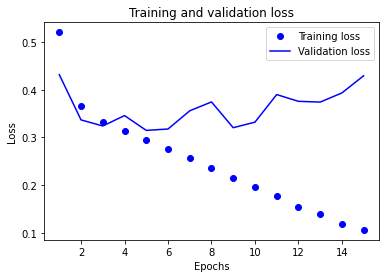

In [87]:
import matplotlib.pyplot as plt

history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

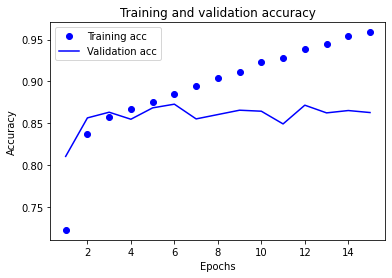

In [88]:
plt.clf()
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [89]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 10, 25)]     0           []                               
                                                                                                  
 time_distributed (TimeDistribu  (None, 10, 300)     37712900    ['input_2[0][0]']                
 ted)                                                                                             
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 10, 300)     406800      ['time_distributed[0][0]']       
 )                                                                                                
                                                                                            

In [ ]:
import seaborn as sn


In [90]:

word_rev_index = {}
for word, i in tokenizer.word_index.items():
    word_rev_index[i] = word


In [91]:
word_rev_index # index 에 매칭되는 단어를 보여줌

{1: 'the',
 2: 'and',
 3: 'a',
 4: 'of',
 5: 'to',
 6: 'is',
 7: 'br',
 8: 'in',
 9: 'it',
 10: 'i',
 11: 'this',
 12: 'that',
 13: 'was',
 14: 'as',
 15: 'for',
 16: 'with',
 17: 'movie',
 18: 'but',
 19: 'film',
 20: 'on',
 21: 'not',
 22: 'you',
 23: 'are',
 24: 'his',
 25: 'have',
 26: 'be',
 27: 'one',
 28: 'he',
 29: 'all',
 30: 'at',
 31: 'by',
 32: 'an',
 33: 'they',
 34: 'so',
 35: 'who',
 36: 'from',
 37: 'like',
 38: 'or',
 39: 'just',
 40: 'her',
 41: 'out',
 42: 'about',
 43: 'if',
 44: "it's",
 45: 'has',
 46: 'there',
 47: 'some',
 48: 'what',
 49: 'good',
 50: 'when',
 51: 'more',
 52: 'very',
 53: 'up',
 54: 'no',
 55: 'time',
 56: 'my',
 57: 'even',
 58: 'would',
 59: 'she',
 60: 'which',
 61: 'only',
 62: 'really',
 63: 'see',
 64: 'story',
 65: 'their',
 66: 'had',
 67: 'can',
 68: 'me',
 69: 'well',
 70: 'were',
 71: 'than',
 72: 'much',
 73: 'we',
 74: 'bad',
 75: 'been',
 76: 'get',
 77: 'do',
 78: 'great',
 79: 'other',
 80: 'will',
 81: 'also',
 82: 'into',
 83

# attention시각화 함수

In [92]:
# word attention 시각화
def sentiment_analysis(review):         # review 에 text가 들어가게됨
    tokenized_sentences = doc2hierarchical(review)  # model 에 넣을수 있는 형태로 변형시켜줌
    
    # word attention만 가져오기
    pred_attention = attention_extractor.predict(np.asarray([tokenized_sentences]))[0][0]
    for sent_idx, sentence in enumerate(tokenized_sentences):
        if sentence[-1] == 0:
            continue
            
        for word_idx in range(MAX_SENTENCE_LENGTH):
            if sentence[word_idx] != 0:
                words = [word_rev_index[word_id] for word_id in sentence[word_idx:]]
                pred_att = pred_attention[sent_idx][-len(words):]
                pred_att = np.expand_dims(pred_att, axis=0)
                break

        fig, ax = plt.subplots(figsize=(len(words), 1))
        plt.rc('xtick', labelsize=16)
        midpoint = (max(pred_att[:, 0]) - min(pred_att[:, 0])) / 2
        heatmap = sn.heatmap(pred_att, xticklabels=words, yticklabels=False, square=True, linewidths=0.1, cmap='coolwarm', center=midpoint, vmin=0, vmax=1)
        plt.xticks(rotation=45)
        plt.show()
        

In [93]:
sent1="Absolute perfection end game !! Good acting performance to all the characters. Great cgi's. Truly epic & perfect ending to a long journey of marvel movie. Go see it you wont regret it !! Perfection Marvel Endgame !!"
tokenized_sentences = doc2hierarchical(sent1) ;tokenized_sentences # (10, 25) 총 10개의 문장으로 이루어짐

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  1591,  3116,   127,   465],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
           49,   113,   241,     5,    29,     1,   102],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,    78, 67633],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,   371,  1630,   399,   272,
            5,     3,   194,  1261,     4,  5815,    17],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
          139,    63,     9,    22,  4007,  2529,     9],


In [94]:
# sentence attention 시각화
def sentiment_sent_analysis(review):         # review 에 text가 들어가게됨
    tokenized_sentences = doc2hierarchical(review)  # model 에 넣을수 있는 형태로 변형시켜줌
    pred_sent_attention = attention_extractor.predict(np.asarray([tokenized_sentences]))[1][0]
    print(pred_sent_attention)


In [95]:
# word_sentence attention 시각화 : word와 sentence를 같이 고려한 attention으로 중요한 단어들만 남게 하자!! 

def wordsent_mult(pred_sent_attention,pred_word_attention):
 #for문 자제함, 속도 느리게 하는 원인이 됨   
  for i in range(len(pred_sent_attention)):    # sentence개수만큼 구해야함 여기서는 10이 나옴   (0~9)
    for j in range(len(pred_word_attention[i])):       # sentence내의 word개수만큼 구해야함  여기서는 25이 나옴 한개 문장을 padding으로 길이 25로 맞춤 (0~24)
      pred_ws_att[i][j] = pred_sent_attention[i] * pred_word_attention[i][j]                               
  return pred_ws_att # 기존 pred_word_attetion과 값이 달라진것을 확인할 수 있음
 


def sentiment_word_sentence_analysis(review):         # review 에 text가 들어가게됨
    tokenized_sentences = doc2hierarchical(review)  # model 에 넣을수 있는 형태로 변형시켜줌
    
    pred_sent_attention = attention_extractor.predict(np.asarray([tokenized_sentences]))[1][0]
    pred_word_attention = attention_extractor.predict(np.asarray([tokenized_sentences]))[0][0] 
    
    pred_ws_att =  pred_word_attention * np.tile(pred_sent_attention, (25, 1)).T # 여기서 pred_ws_att 나오게됨
    
    for sent_idx, sentence in enumerate(tokenized_sentences):
        if sentence[-1] == 0:
            continue
            
        for word_idx in range(MAX_SENTENCE_LENGTH):
            if sentence[word_idx] != 0:
                words = [word_rev_index[word_id] for word_id in sentence[word_idx:]]
                pred_att_ws = pred_ws_att[sent_idx][-len(words):]
                pred_att_ws = np.expand_dims(pred_att_ws, axis=0)
                break

        fig, ax = plt.subplots(figsize=(len(words), 1))
        plt.rc('xtick', labelsize=16)
        midpoint = (max(pred_att[:, 0]) - min(pred_att[:, 0])) / 2
        heatmap = sn.heatmap(pred_att_ws, xticklabels=words, yticklabels=False, square=True, linewidths=0.1, cmap='coolwarm', center=midpoint, vmin=0, vmax=1)
        plt.xticks(rotation=45)
        plt.show()
        

In [96]:
def sentiment_word_sentence_norm_analysis(review):         # review 에 text가 들어가게됨
    tokenized_sentences = doc2hierarchical(review)  # model 에 넣을수 있는 형태로 변형시켜줌
    
    pred_sent_attention = attention_extractor.predict(np.asarray([tokenized_sentences]))[1][0]
    pred_word_attention = attention_extractor.predict(np.asarray([tokenized_sentences]))[0][0] 
    
    pred_ws_att =  pred_word_attention * np.tile(pred_sent_attention, (25, 1)).T # 여기서 pred_ws_att 나오게됨

    # 정규화 시키기
    pred_att = normalize(pred_ws_att, norm='l2', axis=1)

    for sent_idx, sentence in enumerate(tokenized_sentences):
        if sentence[-1] == 0:
            continue
            
        for word_idx in range(MAX_SENTENCE_LENGTH):
            if sentence[word_idx] != 0:
                words = [word_rev_index[word_id] for word_id in sentence[word_idx:]]
                pred_att_ws = pred_att[sent_idx][-len(words):]
                pred_att_ws = np.expand_dims(pred_att_ws, axis=0)
                break

        fig, ax = plt.subplots(figsize=(len(words), 1))
        plt.rc('xtick', labelsize=16)
        midpoint = (max(pred_att[:, 0]) - min(pred_att[:, 0])) / 2
        heatmap = sn.heatmap(pred_att_ws, xticklabels=words, yticklabels=False, square=True, linewidths=0.1, cmap='coolwarm', center=midpoint, vmin=0, vmax=1)
        plt.xticks(rotation=45)
        plt.show()
        

In [97]:
sent1="Absolute perfection end game !! Good acting performance to all the characters. Great cgi's. Truly epic & perfect ending to a long journey of marvel movie. Go see it you wont regret it !! Perfection Marvel Endgame !!"



# 시각화 예제

In [ ]:
sent1="Absolute perfection end game !! Good acting performance to all the characters. Great cgi's. Truly epic & perfect ending to a long journey of marvel movie. Go see it you wont regret it !! Perfection Marvel Endgame !!"
tokenized_sentences = doc2hierarchical(sent1) ;tokenized_sentences # (10, 25) 총 10개의 문장으로 이루어짐

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  1591,  3116,   127,   465],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
           49,   113,   241,     5,    29,     1,   102],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,    78, 67633],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,   371,  1630,   399,   272,
            5,     3,   194,  1261,     4,  5815,    17],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
          139,    63,     9,    22,  4007,  2529,     9],


In [ ]:
pred_word_attention = attention_extractor.predict(np.asarray([tokenized_sentences]))[0][0] ;pred_word_attention  # (10, 25) 
# 각 문장의 단어에 대한 attention score값을 알 수 있음
pred_ws_att = pred_word_attention     # pred_att를  pred_word_attention의 모양을 그대로 가져오고자함

In [ ]:
pred_sent_attention = attention_extractor.predict(np.asarray([tokenized_sentences]))[1][0] ;pred_sent_attention  # (10, ) 10개 문장에대한  attention값이 나옴

array([0.11101179, 0.12635273, 0.02672192, 0.51642346, 0.0705208 ,
       0.13546988, 0.00446897, 0.00305323, 0.00295512, 0.00302207],
      dtype=float32)

In [ ]:
print(pred_sent_attention)
print(np.tile(pred_sent_attention, (25, 1)).T)
print((np.tile(pred_sent_attention, (25, 1)).T).shape) # (10, 25)

[0.11101179 0.12635273 0.02672192 0.51642346 0.0705208  0.13546988
 0.00446897 0.00305323 0.00295512 0.00302207]
[[0.11101179 0.11101179 0.11101179 0.11101179 0.11101179 0.11101179
  0.11101179 0.11101179 0.11101179 0.11101179 0.11101179 0.11101179
  0.11101179 0.11101179 0.11101179 0.11101179 0.11101179 0.11101179
  0.11101179 0.11101179 0.11101179 0.11101179 0.11101179 0.11101179
  0.11101179]
 [0.12635273 0.12635273 0.12635273 0.12635273 0.12635273 0.12635273
  0.12635273 0.12635273 0.12635273 0.12635273 0.12635273 0.12635273
  0.12635273 0.12635273 0.12635273 0.12635273 0.12635273 0.12635273
  0.12635273 0.12635273 0.12635273 0.12635273 0.12635273 0.12635273
  0.12635273]
 [0.02672192 0.02672192 0.02672192 0.02672192 0.02672192 0.02672192
  0.02672192 0.02672192 0.02672192 0.02672192 0.02672192 0.02672192
  0.02672192 0.02672192 0.02672192 0.02672192 0.02672192 0.02672192
  0.02672192 0.02672192 0.02672192 0.02672192 0.02672192 0.02672192
  0.02672192]
 [0.51642346 0.51642346 0.516

In [ ]:
# pred_sent_attention * pred_attention 을 곱해서  word의 sentence를 고려한 word attention을 구할 수 있으
pred_ws_att = pred_word_attention * np.tile(pred_sent_attention, (25, 1)).T # pred_att를  pred_word_attention의 모양을 그대로 가져오고자함

# for i in range(len(pred_sent_attention)):    # sentence개수만큼 구해야함 여기서는 10이 나옴
#   for j in range(len(pred_word_attention[i])):       # sentence내의 word개수만큼 구해야함  여기서는 25이 나옴 한개 문장을 padding으로 길이 25로 맞춤
#        pred_ws_att[i][j] = pred_sent_attention[i] * pred_word_attention[i][j]                               

# attention 값이 바뀐것을 확인할 수 있음
print(pred_ws_att[1])  # 기존 pred_word_attetion과 값이 달라진것을 확인할 수 있음
print(pred_word_attention[1])

[7.2786469e-07 6.8984787e-07 6.8537429e-07 6.8397958e-07 6.8369525e-07
 6.8394178e-07 6.8439590e-07 6.8491039e-07 6.8542272e-07 6.8591709e-07
 6.8640713e-07 6.8694351e-07 6.8763427e-07 6.8877500e-07 6.9139429e-07
 7.0071411e-07 7.4041861e-07 9.2450330e-07 2.3857806e-02 6.0130161e-04
 3.0206898e-04 1.5442638e-05 8.9938880e-04 2.7825910e-04 2.9031871e-04]
[2.4488793e-06 2.3209727e-06 2.3059215e-06 2.3012290e-06 2.3002724e-06
 2.3011019e-06 2.3026298e-06 2.3043608e-06 2.3060845e-06 2.3077478e-06
 2.3093965e-06 2.3112011e-06 2.3135251e-06 2.3173632e-06 2.3261757e-06
 2.3575319e-06 2.4911164e-06 3.1104639e-06 8.0268882e-02 2.0230615e-03
 1.0163022e-03 5.1956296e-05 3.0259669e-03 9.3619456e-04 9.7676867e-04]


In [ ]:
pred_sent_attention = attention_extractor.predict(np.asarray([tokenized_sentences]))[1][0]
pred_word_attention = attention_extractor.predict(np.asarray([tokenized_sentences]))[0][0] 

In [ ]:
pred_ws_att[0][0] = pred_sent_attention[0] * pred_word_attention[0][0]   ; pred_ws_att[0][0]

1.150294e-05

In [ ]:
pred_sent_attention[0]

0.15108556

In [ ]:
pred_word_attention[0][0] 

0.04157463

In [ ]:
pred_ws_att_mat = np.array(pred_ws_att) ;pred_ws_att_mat

array([[9.6137745e-05, 9.2632523e-05, 9.2343565e-05, 9.2338902e-05,
        9.2364084e-05, 9.2385228e-05, 9.2399852e-05, 9.2409187e-05,
        9.2414492e-05, 9.2416238e-05, 9.2415008e-05, 9.2411487e-05,
        9.2406459e-05, 9.2401795e-05, 9.2400383e-05, 9.2408496e-05,
        9.2438109e-05, 9.2521019e-05, 9.2751587e-05, 9.3160976e-05,
        9.3509370e-05, 8.5284404e-02, 6.8331808e-01, 8.3170757e-02,
        1.4628007e-01],
       [8.6226290e-05, 8.2189559e-05, 8.1862338e-05, 8.1864993e-05,
        8.1903338e-05, 8.1937789e-05, 8.1965773e-05, 8.1988990e-05,
        8.2009006e-05, 8.2027545e-05, 8.2046405e-05, 8.2069411e-05,
        8.2103696e-05, 8.2164159e-05, 8.2298342e-05, 8.2722938e-05,
        8.4008578e-05, 8.6799540e-05, 7.1248424e-01, 2.4990421e-02,
        1.7936912e-01, 1.2503319e-02, 3.1699967e-02, 2.1486828e-02,
        1.5977832e-02],
       [3.8897173e-04, 3.6841579e-04, 3.6674974e-04, 3.6675343e-04,
        3.6693166e-04, 3.6708760e-04, 3.6720734e-04, 3.6730000e-04,


In [ ]:
from sklearn.preprocessing import normalize
pred_sent_attention_2d = np.reshape(pred_sent_attention,(10,1))
w_normalized = normalize(pred_sent_attention_2d, norm='l2', axis=0)
# axis=1는 행으로 정규화해야하고 axis=0는 열로 정규화해야합니다. 선택적 인수 copy=False를 사용하여 행렬을 수정하십시오.
print(w_normalized)
print(pred_sent_attention)

[[0.19652928]
 [0.22368807]
 [0.04730705]
 [0.9142483 ]
 [0.12484623]
 [0.23982859]
 [0.00791163]
 [0.00540528]
 [0.00523158]
 [0.00535012]]
[0.11101179 0.12635273 0.02672192 0.51642346 0.0705208  0.13546988
 0.00446897 0.00305323 0.00295512 0.00302207]


In [ ]:
w_normalized = normalize(pred_ws_att, norm='l2', axis=1)


print(w_normalized)
print(pred_ws_att)

[[1.35619004e-04 1.30674278e-04 1.30266650e-04 1.30260072e-04
  1.30295593e-04 1.30325425e-04 1.30346059e-04 1.30359229e-04
  1.30366709e-04 1.30369168e-04 1.30367436e-04 1.30362474e-04
  1.30355373e-04 1.30348795e-04 1.30346802e-04 1.30358254e-04
  1.30400018e-04 1.30516986e-04 1.30842236e-04 1.31419758e-04
  1.31911220e-04 1.20308481e-01 9.63938951e-01 1.17326811e-01
  2.06353456e-01]
 [1.17088952e-04 1.11607369e-04 1.11163026e-04 1.11166635e-04
  1.11218702e-04 1.11265486e-04 1.11303489e-04 1.11335015e-04
  1.11362198e-04 1.11387373e-04 1.11412977e-04 1.11444220e-04
  1.11490779e-04 1.11572881e-04 1.11755093e-04 1.12331662e-04
  1.14077462e-04 1.17867385e-04 9.67501163e-01 3.39351520e-02
  2.43570060e-01 1.69785880e-02 4.30462211e-02 2.91775316e-02
  2.16967184e-02]
 [4.18326439e-04 3.96219199e-04 3.94427421e-04 3.94431379e-04
  3.94623057e-04 3.94790783e-04 3.94919538e-04 3.95019189e-04
  3.95096984e-04 3.95156501e-04 3.95201409e-04 3.95233801e-04
  3.95256968e-04 3.95276933e-04 3.

In [ ]:
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
transformer = StandardScaler()
transformer.fit(pred_sent_attention) #StandardScaler 모델에 x_train_df 데이터 적용 (평균, 표준편차 계산)
#print(transformer.mean_) #[5.16666667 5.75      ]
#print(transformer.var_) #[ 6.80555556 12.02083333]
#print(transformer.scale_) #[2.60874597 3.46710734]
x_data = transformer.transform(pred_sent_attention)
print(x_data)

#normalize(pred_sent_attention, axis=1).ravel()

ValueError: ignored

In [ ]:
norm = np.linalg.norm(pred_sent_attention, axis =0) ; norm

0.5648613

In [ ]:
np.tile(norm, (25, 1)).T

array([[0.20006531, 0.20006531, 0.20006531, 0.20006531, 0.20006531,
        0.20006531, 0.20006531, 0.20006531, 0.20006531, 0.20006531,
        0.20006531, 0.20006531, 0.20006531, 0.20006531, 0.20006531,
        0.20006531, 0.20006531, 0.20006531, 0.20006531, 0.20006531,
        0.20006531, 0.20006531, 0.20006531, 0.20006531, 0.20006531],
       [0.20011133, 0.20011133, 0.20011133, 0.20011133, 0.20011133,
        0.20011133, 0.20011133, 0.20011133, 0.20011133, 0.20011133,
        0.20011133, 0.20011133, 0.20011133, 0.20011133, 0.20011133,
        0.20011133, 0.20011133, 0.20011133, 0.20011133, 0.20011133,
        0.20011133, 0.20011133, 0.20011133, 0.20011133, 0.20011133],
       [0.20034975, 0.20034975, 0.20034975, 0.20034975, 0.20034975,
        0.20034975, 0.20034975, 0.20034975, 0.20034975, 0.20034975,
        0.20034975, 0.20034975, 0.20034975, 0.20034975, 0.20034975,
        0.20034975, 0.20034975, 0.20034975, 0.20034975, 0.20034975,
        0.20034975, 0.20034975, 0.20034975, 0.

In [ ]:
a= pred_word_attention / np.tile(norm, (25, 1)).T ; a

array([[0.20780529, 0.20730865, 0.20628875, 0.20505401, 0.20387298,
        0.20279817, 0.20183119, 0.20096709, 0.20019846, 0.19951372,
        0.19889617, 0.19832331, 0.19776587, 0.19718622, 0.19653708,
        0.19576252, 0.19480766, 0.19364627, 0.19232939, 0.19101207,
        0.19009896, 0.20484851, 0.20705678, 0.19989844, 0.20456034],
       [0.20687416, 0.20641196, 0.20542324, 0.20421834, 0.20306563,
        0.20201673, 0.20107083, 0.20021865, 0.19944519, 0.19872674,
        0.19802834, 0.19730125, 0.19648252, 0.1954996 , 0.19428657,
        0.19281155, 0.19108059, 0.18928505, 0.19227944, 0.20783828,
        0.22139268, 0.20384803, 0.19483502, 0.19596343, 0.19881462],
       [0.21296512, 0.21241888, 0.21133997, 0.21004058, 0.20879376,
        0.207652  , 0.20661639, 0.2056815 , 0.20484008, 0.20408122,
        0.20339009, 0.20274782, 0.20213118, 0.20151173, 0.200854  ,
        0.2001128 , 0.19923061, 0.19813597, 0.19674724, 0.19498529,
        0.1927833 , 0.19001848, 0.18625616, 0.

In [ ]:
import matplotlib.pyplot as plt


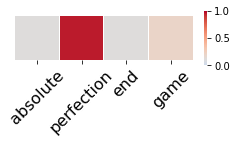

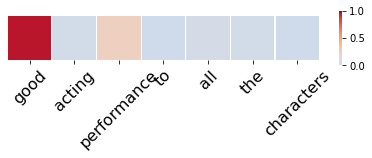

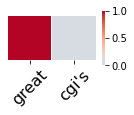

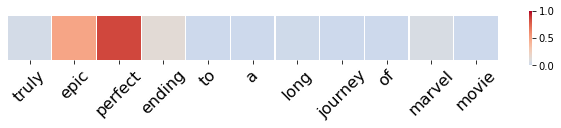

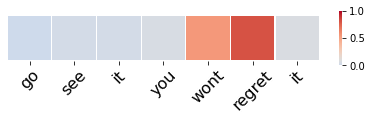

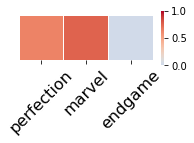

In [ ]:
sentiment_word_sentence_norm_analysis(sent1)

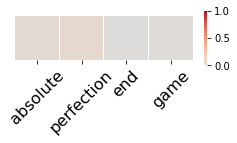

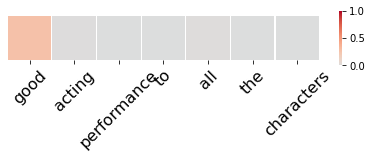

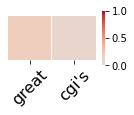

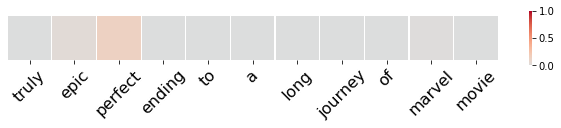

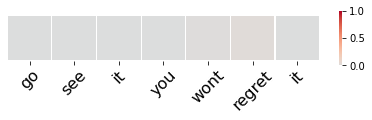

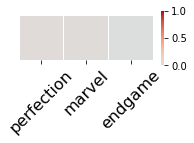

In [ ]:
sentiment_word_sentence_analysis(sent1)

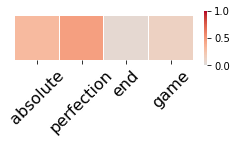

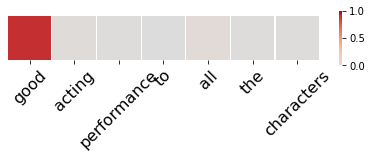

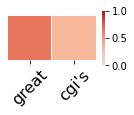

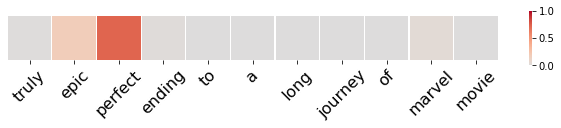

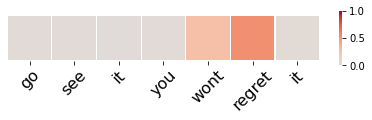

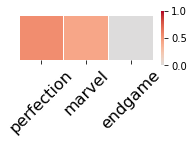

In [ ]:
sentiment_analysis(sent1)

In [ ]:

#    word_attention_extractor = Model(inputs=[sentence_input], outputs=[word_attention])
#    word_attentions = TimeDistributed(word_attention_extractor)(document_input)
#    attention_extractor = Model(inputs=[document_input], outputs=[word_attentions, sentence_attention])

def sentiment_sent_analysis(review):         # review 에 text가 들어가게됨
    tokenized_sentences = doc2hierarchical(review)  # model 에 넣을수 있는 형태로 변형시켜줌
    pred_sent_attention = attention_extractor.predict(np.asarray([tokenized_sentences]))[1][0]
    print(pred_sent_attention)
#    for sent_idx, doc in enumerate(tokenized_sentences):  # len(tokenized_sentences) = 문장의 개수 문장개수만큼 attention 계산함
#        if doc[-1] == 0:
#            continue
            
#        for sentence_idx in range(len(tokenized_sentences)):
#            if doc[sentence_idx] != 0:
                # words = [word_rev_index[word_id] for word_id in doc[word_idx:]]
#                pred_att = pred_sent_attention[sent_idx][-len(words):]
#                pred_att = np.expand_dims(pred_sent_att, axis=0)
 #               break

#        fig, ax = plt.subplots(figsize=(len(words), 1))
#        plt.rc('xtick', labelsize=16)
#        midpoint = (max(pred_att[:, 0]) - min(pred_att[:, 0])) / 2
#        heatmap = sn.heatmap(pred_att, xticklabels=words, yticklabels=False, square=True, linewidths=0.1, cmap='coolwarm', center=midpoint, vmin=0, vmax=1)
#        plt.xticks(rotation=45)
#        plt.show()


array([0.15108556, 0.2972236 , 0.25681004, 0.1944112 , 0.05340075,
       0.0442016 , 0.00086487, 0.00068306, 0.00067037, 0.00064894],
      dtype=float32)

In [ ]:
len(pred_sent_attention)

10

In [ ]:
len(pred_word_attention[2])

25

In [ ]:
 pred_word_attention[1][1]  

2.6272624e-05

In [ ]:
pred_sent_attention[1]

0.2972236

In [ ]:
pred_sent_attention[1] * pred_word_attention[1][1]  

7.808844e-06

In [ ]:
pred_att_sample = pred_word_attention
type(pred_att_sample)
pred_att_sample[0][0] = 1
pred_att_sample

array([[1.00000000e+00, 7.36664151e-05, 7.33621418e-05, 7.32623012e-05,
        7.32354820e-05, 7.32419066e-05, 7.32603512e-05, 7.32806802e-05,
        7.32985063e-05, 7.33119232e-05, 7.33203124e-05, 7.33240959e-05,
        7.33242341e-05, 7.33222769e-05, 7.33215056e-05, 7.33270281e-05,
        7.33485067e-05, 7.34188361e-05, 7.36741422e-05, 7.50292893e-05,
        7.88638790e-05, 3.16130757e-01, 4.72914219e-01, 6.32230937e-02,
        1.46181628e-01],
       [2.77204836e-05, 2.62726244e-05, 2.61022506e-05, 2.60491324e-05,
        2.60383040e-05, 2.60476918e-05, 2.60649886e-05, 2.60845827e-05,
        2.61040932e-05, 2.61229216e-05, 2.61415862e-05, 2.61620135e-05,
        2.61883215e-05, 2.62317644e-05, 2.63315196e-05, 2.66864608e-05,
        2.81985922e-05, 3.52093957e-05, 9.08616483e-01, 2.29003709e-02,
        1.15041966e-02, 5.88127645e-04, 3.42529193e-02, 1.05974050e-02,
        1.10566905e-02],
       [1.24888305e-04, 1.20929704e-04, 1.20449287e-04, 1.20295226e-04,
        1.2025

In [ ]:
type(pred_attention)

numpy.ndarray

array([[1.15029397e-05, 1.11299314e-05, 1.10839601e-05, 1.10688752e-05,
        1.10648234e-05, 1.10657938e-05, 1.10685805e-05, 1.10716519e-05,
        1.10743458e-05, 1.10763731e-05, 1.10776400e-05, 1.10782121e-05,
        1.10782330e-05, 1.10779365e-05, 1.10778201e-05, 1.10786550e-05,
        1.10819001e-05, 1.10925257e-05, 1.11310983e-05, 1.13358419e-05,
        1.19151928e-05, 4.77627926e-02, 7.14505091e-02, 9.55209602e-03,
        2.20859330e-02],
       [8.23918162e-06, 7.80884420e-06, 7.75820445e-06, 7.74241653e-06,
        7.73919874e-06, 7.74198907e-06, 7.74712953e-06, 7.75295393e-06,
        7.75875287e-06, 7.76434899e-06, 7.76989600e-06, 7.77596779e-06,
        7.78378671e-06, 7.79669972e-06, 7.82634925e-06, 7.93184608e-06,
        8.38128744e-06, 1.04650635e-05, 2.70062268e-01, 6.80653052e-03,
        3.41931870e-03, 1.74805420e-04, 1.01807760e-02, 3.14979884e-03,
        3.28630931e-03],
       [3.20725703e-05, 3.10559626e-05, 3.09325878e-05, 3.08930212e-05,
        3.0883

In [ ]:
len(tokenized_sentences)

10

In [ ]:
sentiment_sent_analysis(sent1)

[0.10412683 0.42043734 0.02562917 0.32664895 0.08191442 0.02769754
 0.00366709 0.00330669 0.00326987 0.00330221]


In [ ]:
tokenized_sentences = doc2hierarchical(sent1) ;tokenized_sentences  # 각각의 단어를 padding 25로 맞춤 한 문장의 단어 수 25개까지 받음

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,  1591,  3116,   127,   465],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
           49,   113,   241,     5,    29,     1,   102],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,    78, 67633],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,   371,  1630,   399,   272,
            5,     3,   194,  1261,     4,  5815,    17],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
          139,    63,     9,    22,  4007,  2529,     9],


In [ ]:
pred_attention = attention_extractor.predict(np.asarray([tokenized_sentences]))[0][0] ; pred_attention

array([[2.51648104e-04, 2.44007140e-04, 2.42095790e-04, 2.41363610e-04,
        2.41011687e-04, 2.40816400e-04, 2.40704365e-04, 2.40644673e-04,
        2.40620808e-04, 2.40624489e-04, 2.40651338e-04, 2.40699766e-04,
        2.40770925e-04, 2.40869223e-04, 2.41002970e-04, 2.41187809e-04,
        2.41456626e-04, 2.41898932e-04, 2.42686612e-04, 2.45765928e-04,
        2.46998330e-04, 3.26069444e-01, 4.48774517e-01, 7.62246102e-02,
        1.43843934e-01],
       [6.34506141e-05, 6.12678123e-05, 6.07304573e-05, 6.05297064e-05,
        6.04372981e-05, 6.03902809e-05, 6.03684057e-05, 6.03632216e-05,
        6.03710578e-05, 6.03904009e-05, 6.04218003e-05, 6.04679699e-05,
        6.05358255e-05, 6.06415633e-05, 6.08299888e-05, 6.12488730e-05,
        6.29635688e-05, 6.61362646e-05, 9.18018579e-01, 2.32745688e-02,
        1.09368237e-02, 3.33800708e-04, 1.08969845e-02, 1.43945999e-02,
        2.10429840e-02],
       [2.71908593e-05, 2.63955590e-05, 2.62007143e-05, 2.61273053e-05,
        2.6092

In [ ]:
for sent_idx, sentence in enumerate(tokenized_sentences):
    if sentence[-1] == 0:
        continue
        
    for word_idx in range(MAX_SENTENCE_LENGTH):
        if sentence[word_idx] != 0:
            words = [word_rev_index[word_id] for word_id in sentence[word_idx:]]
            pred_att = pred_attention[sent_idx][-len(words):]
            pred_att = np.expand_dims(pred_att, axis=0)
            break

In [ ]:
# 가장 마지막 단어의 attention임을 알 수 있음
pred_att # perfection. marvel, endgame

array([[0.38078085, 0.5167992 , 0.1015916 ]], dtype=float32)

In [ ]:
sentiment_word_sentence_analysis("Absolute perfection end game !! Good acting performance to all the characters. Great cgi's. Truly epic & perfect ending to a long journey of marvel movie. Go see it you wont regret it !! Perfection Marvel Endgame !!")


NameError: ignored

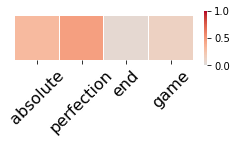

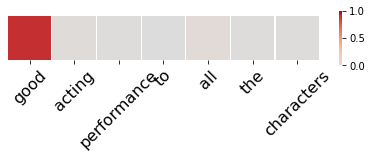

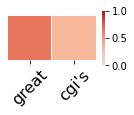

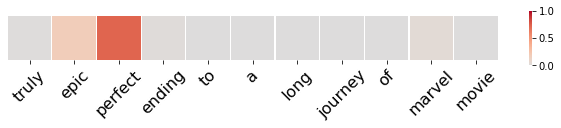

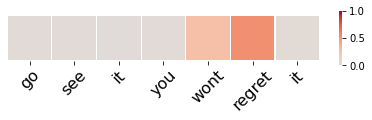

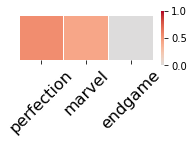

In [ ]:
sentiment_analysis("Absolute perfection end game !! Good acting performance to all the characters. Great cgi's. Truly epic & perfect ending to a long journey of marvel movie. Go see it you wont regret it !! Perfection Marvel Endgame !!")
# 총 6개의 문장으로 이루어짐

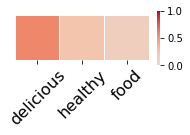

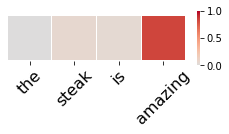

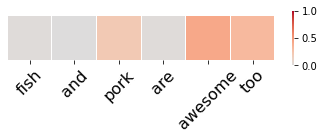

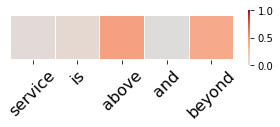

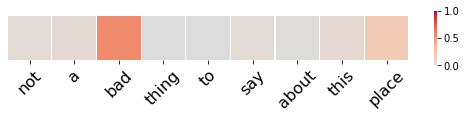

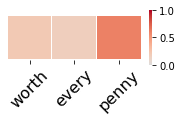

In [ ]:
sentiment_analysis("Delicious healthy food. The steak is amazing. Fish and pork are awesome too. Service is above and beyond. Not a bad thing to say about this place. Worth every penny!")

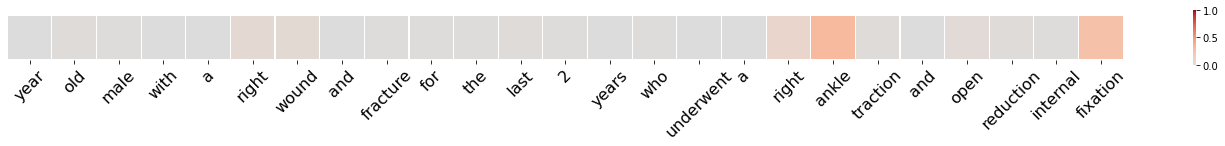

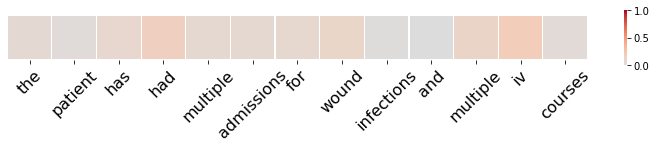

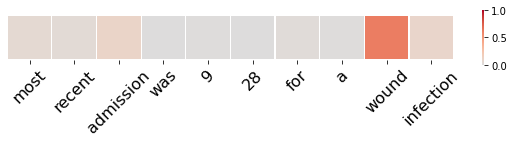

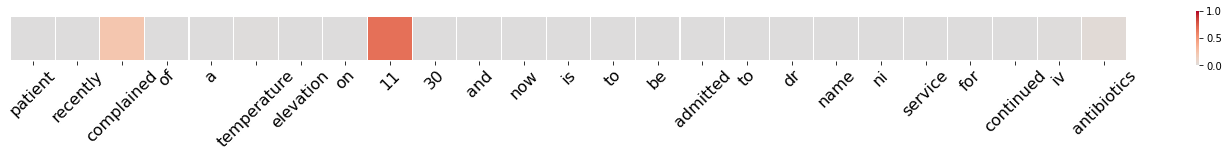

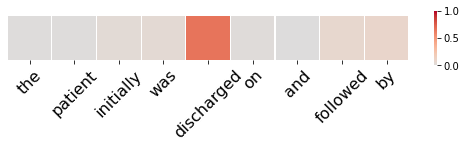

In [ ]:
sentiment_analysis('''**HISTORY OF PRESENT ILLNESS:**  This is a 66-year-old male with
a nonhealing right malleolar wound and fracture for the last
2 years who underwent a right ankle traction and open
reduction internal fixation. The patient has had multiple
admissions for wound infections and multiple IV antibiotic
courses. Most recent admission was [**2189-9-28**], for a
wound infection. The patient recently complained of a
temperature elevation on [**2189-11-30**], and now is to be
admitted to Dr.[**Name (NI) 1392**] service for continued IV
antibiotics. The patient initially was discharged on
daptomycin and followed by VNA.
''')

In [ ]:
# sentence attention 수치 뽑기
sentiment_sent_analysis("Absolute perfection end game !! Good acting performance to all the characters. Great cgi's. Truly epic & perfect ending to a long journey of marvel movie. Go see it you wont regret it !! Perfection Marvel Endgame !!")



In [ ]:
# word attention 시각화
def sentiment_analysis(review):         # review 에 text가 들어가게됨
    tokenized_sentences = doc2hierarchical(review)  # model 에 넣을수 있는 형태로 변형시켜줌
    
    # word attention만 가져오기
    pred_attention = attention_extractor.predict(np.asarray([tokenized_sentences]))[0][0]
    for sent_idx, sentence in enumerate(tokenized_sentences):
        if sentence[-1] == 0:
            continue
            
        for word_idx in range(MAX_SENTENCE_LENGTH):
            if sentence[word_idx] != 0:
                words = [word_rev_index[word_id] for word_id in sentence[word_idx:]]
                pred_att = pred_attention[sent_idx][-len(words):]
                pred_att = np.expand_dims(pred_att, axis=0)
                break


# 주요 단어만 추출하기

In [300]:

import pandas as pd

df = pd.DataFrame(columns = {'word','att','logic'}) 
word_list = []
att_list = []
#word_list = pd.DataFrame(columns = {'word'}) 
#att_list = pd.DataFrame(columns = {'att'}) 
df

for sent_idx, sentence in enumerate(tokenized_sentences):
    if sentence[-1] == 0:
        continue
        
    for word_idx in range(MAX_SENTENCE_LENGTH):
        if sentence[word_idx] != 0 :  # word index 가 0이 아닌 부분만 붙이기 / 필요한 word들만 뽑음
            words = [word_rev_index[word_id] for word_id in sentence[word_idx:]]  
            pred_att = pred_attention[sent_idx][-len(words):]
            # pred_att = np.expand_dims(pred_att, axis=0)
            print(words)
            print(pred_att)
            for i  in range(len(words)):
              word_list.append(words[i])
              att_list.append(pred_att[i]) # [word_idx]
            break
    word_list.append(".")
    att_list.append(0)
        
df['word'] = word_list 
df['att'] = att_list
df

['absolute', 'perfection', 'end', 'game']
[0.16116576 0.585602   0.11041432 0.14158988]
['good', 'acting', 'performance', 'to', 'all', 'the', 'characters']
[7.9890293e-01 5.9305452e-02 4.2103030e-02 6.1349804e-04 4.7786135e-02
 3.4467150e-02 1.5702384e-02]
['great', "cgi's"]
[0.9925154  0.00637273]
['truly', 'epic', 'perfect', 'ending', 'to', 'a', 'long', 'journey', 'of', 'marvel', 'movie']
[1.50569668e-02 2.02618033e-01 6.06341124e-01 2.06315964e-02
 2.09072081e-04 2.14540679e-03 1.82590596e-02 6.75654458e-03
 3.75984819e-04 1.17218494e-01 1.00847250e-02]
['go', 'see', 'it', 'you', 'wont', 'regret', 'it']
[0.04855189 0.06475572 0.08488308 0.07468578 0.17023194 0.52431756
 0.02494328]
['perfection', 'marvel', 'endgame']
[0.41119236 0.5139444  0.07425467]


,logic,word,att
0,NaN,absolute,0.161166
1,NaN,perfection,0.585602
2,NaN,end,0.110414
3,NaN,game,0.141590
4,NaN,.,0.000000
5,NaN,good,0.798903
6,NaN,acting,0.059305
7,NaN,performance,0.042103
8,NaN,to,0.000613
9,NaN,all,0.047786


In [301]:
threshold = 0.1
for i in range(len(df)):
  if df['att'][i] > threshold  : 
    df['logic'][i] = 1
  else:
    df['logic'][i] = 0
print(len(df))
print(df)


40
   logic         word       att
0      1     absolute  0.161166
1      1   perfection  0.585602
2      1          end  0.110414
3      1         game  0.141590
4      0            .  0.000000
5      1         good  0.798903
6      0       acting  0.059305
7      0  performance  0.042103
8      0           to  0.000613
9      0          all  0.047786
10     0          the  0.034467
11     0   characters  0.015702
12     0            .  0.000000
13     1        great  0.992515
14     0        cgi's  0.006373
15     0            .  0.000000
16     0        truly  0.015057
17     1         epic  0.202618
18     1      perfect  0.606341
19     0       ending  0.020632
20     0           to  0.000209
21     0            a  0.002145
22     0         long  0.018259
23     0      journey  0.006757
24     0           of  0.000376
25     1       marvel  0.117218
26     0        movie  0.010085
27     0            .  0.000000
28     0           go  0.048552
29     0          see  0.064756
30   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


TypeError: ignored

In [303]:
#df_ = df[df['logic']==1]  
df_ = df[(df['logic'] == 1) | (df['word'] == '.')]
print(len(df_))

df_=df_.reset_index()
print(df_)
# 19로 길이가 줄어든것을 확인할 수 있음

19
    index logic        word       att
0       0     1    absolute  0.161166
1       1     1  perfection  0.585602
2       2     1         end  0.110414
3       3     1        game  0.141590
4       4     0           .  0.000000
5       5     1        good  0.798903
6      12     0           .  0.000000
7      13     1       great  0.992515
8      15     0           .  0.000000
9      17     1        epic  0.202618
10     18     1     perfect  0.606341
11     25     1      marvel  0.117218
12     27     0           .  0.000000
13     32     1        wont  0.170232
14     33     1      regret  0.524318
15     35     0           .  0.000000
16     36     1  perfection  0.411192
17     37     1      marvel  0.513944
18     39     0           .  0.000000


In [304]:
paragraph = []
for i in range(len(df_)) : 
  paragraph.append(df_['word'][i])

In [306]:
print(paragraph) # 한개의 다큐먼트에서 중요한 단어들만 뽑아서 만든 단어 조합임

['absolute', 'perfection', 'end', 'game', '.', 'good', '.', 'great', '.', 'epic', 'perfect', 'marvel', '.', 'wont', 'regret', '.', 'perfection', 'marvel', '.']


In [309]:
full_paragraph = " ".join(paragraph);  full_paragraph  # attention스코어가 threshold이상인 줄어든 문장을 확인할 수 있음 
# 해당 문장을 기존 모델에 넣었을때의 성능일 비교해볼 수 있음

'absolute perfection end game . good . great . epic perfect marvel . wont regret . perfection marvel .'